<a href="https://colab.research.google.com/github/AgniKoko/Fetal_ECG_Separation/blob/agni/Fetal_ECG_Separation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECG Example



## Requirements

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install wfdb
!pip install scikit-learn
!pip install matplotlib
!pip install pyedflib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 78.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyedflib: filename=pyedflib-0.1.40-cp311-cp311-linux_x86_64.whl size=2734949 sha256=42cbe96a5ad6d3d160050107

In [3]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.decomposition import FastICA
import os
import zipfile
import pyedflib

In [4]:
data_dir = '/content/drive/MyDrive/ColabNotebooks/Fetal_ECG_Separation'
database_zip = os.path.join(data_dir, 'database-1.0.0.zip')

# train_dir = '/content/train/'
# os.makedirs(train_dir, exist_ok=True)

with zipfile.ZipFile(database_zip, 'r') as zip_ref:
    zip_ref.extractall('/content')

print("Dataset extracted successfully.")

Dataset extracted successfully.


## Testing

Signal Labels: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling frequency (fs): 1000.0
Σχήμα signals: (300000, 5)


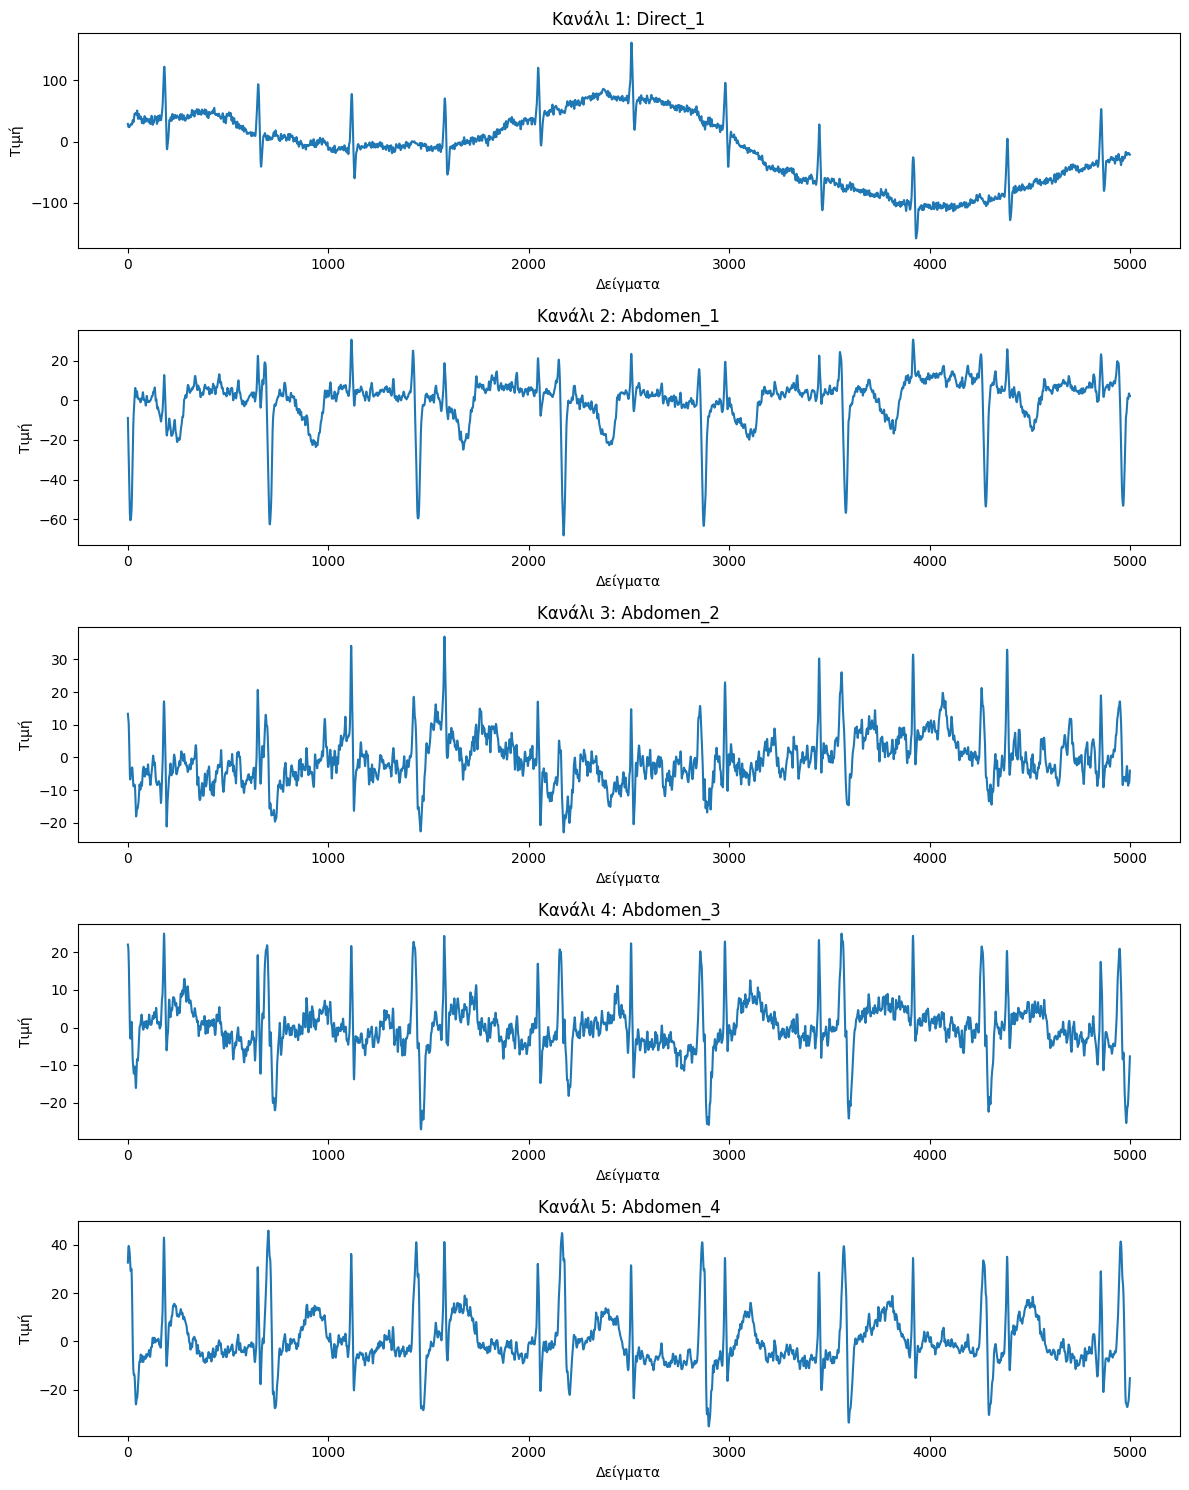

In [24]:
# Ορισμός της διαδρομής προς το EDF αρχείο
file_path = '/content/abdominal-and-direct-fetal-ecg-database-1.0.0/r01.edf'

# Άνοιγμα του EDF αρχείου
f = pyedflib.EdfReader(file_path)

# Εμφάνιση των ονομάτων των καναλιών
n_signals = f.signals_in_file
signal_labels = f.getSignalLabels()
print("Signal Labels:", signal_labels)

# Ανάγνωση όλων των καναλιών και αποθήκευση σε λίστα
signals_list = [f.readSignal(i) for i in range(n_signals)]
fs = f.getSampleFrequency(0)
print("Sampling frequency (fs):", fs)

f._close()  # Κλείσιμο του αρχείου

# Μετατροπή της λίστας σε NumPy array και transpose για να έχουμε σχήμα (δείγματα x κανάλια)
signals = np.array(signals_list).T
print("Σχήμα signals:", signals.shape)

# Επιλογή των πρώτων 5 δευτερολέπτων (για fs=1000, αυτό σημαίνει 5000 δείγματα)
n_sec = 5
first_n_sec = signals[:n_sec * int(fs), :]

# Οπτικοποίηση κάθε καναλιού σε διαφορετικό subplot
n_channels = first_n_sec.shape[1]
plt.figure(figsize=(12, 3 * n_channels))
for i in range(n_channels):
    plt.subplot(n_channels, 1, i + 1)
    plt.plot(first_n_sec[:, i])
    plt.title(f'Κανάλι {i+1}: {signal_labels[i]}')
    plt.xlabel('Δείγματα')
    plt.ylabel('Τιμή')

plt.tight_layout()
plt.show()


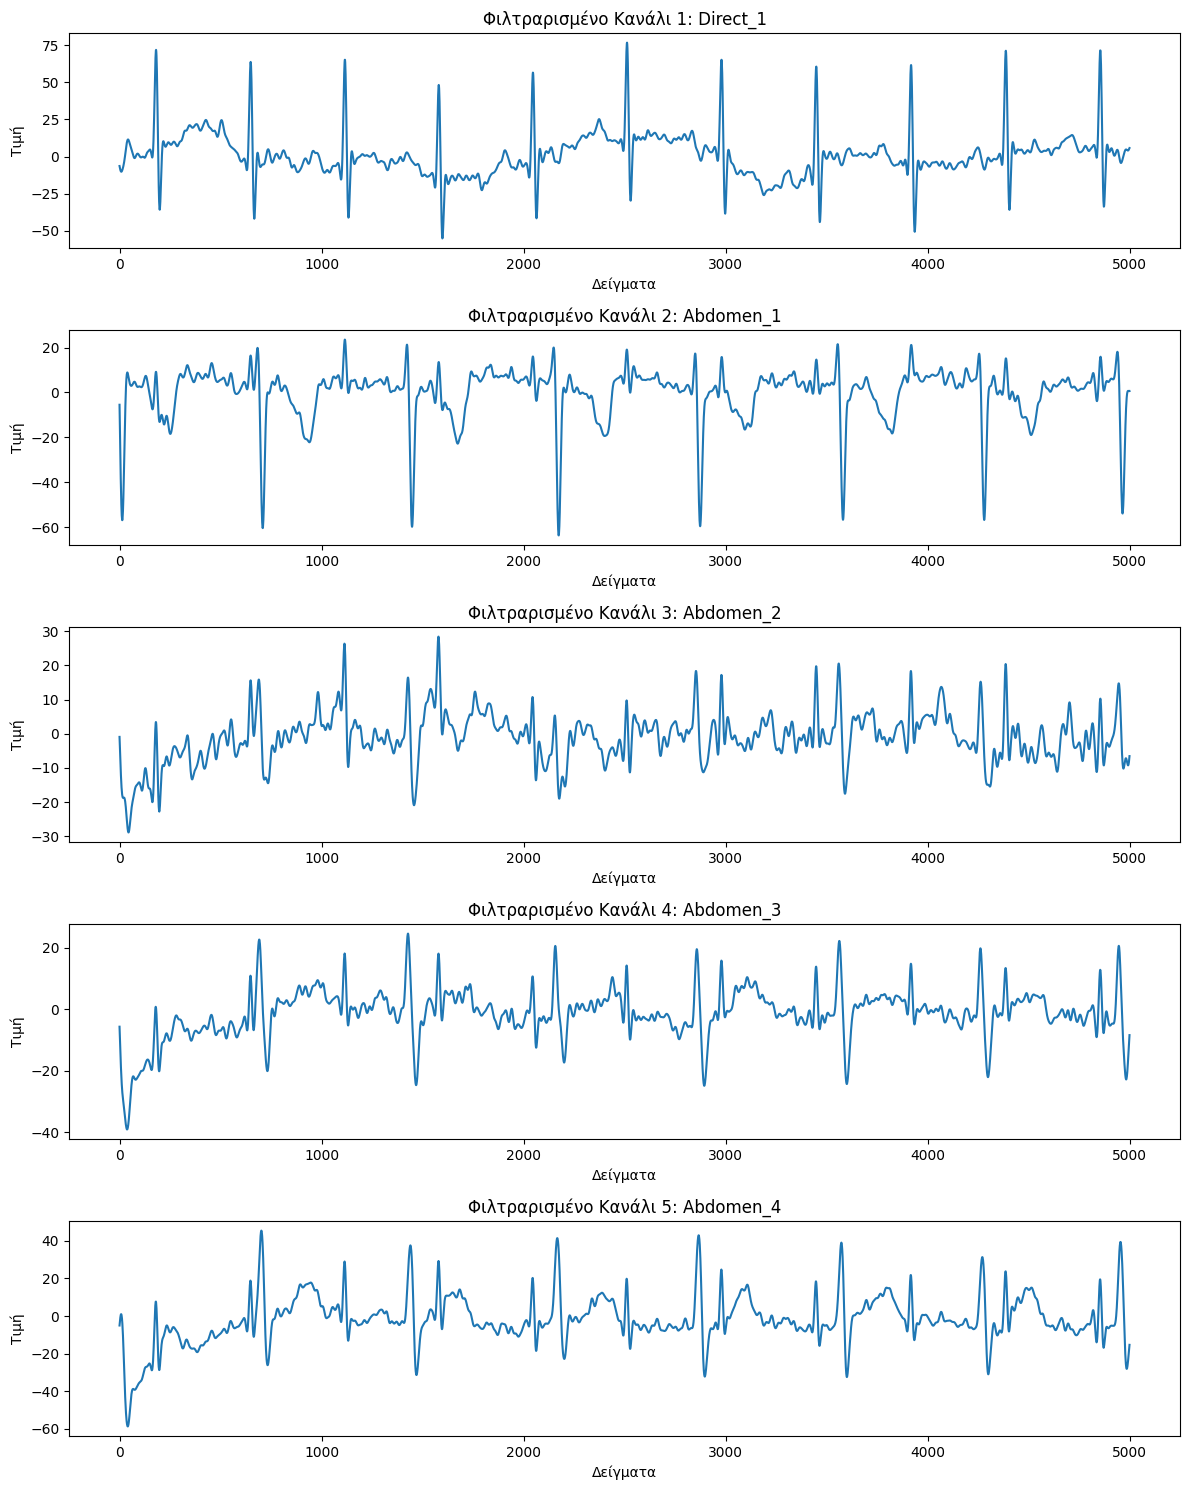

In [6]:
# Συνάρτηση για ζωνοπερατό (bandpass) φιλτράρισμα
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs  # συχνότητα Nyquist
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Ορισμός παραμέτρων φίλτρου
lowcut = 0.5   # Κατώφλι (Hz)
highcut = 40   # Άνω φράγμα (Hz)

# Εφαρμογή του φίλτρου σε κάθε κανάλι του σήματος
filtered_signals = np.zeros_like(signals)
for i in range(signals.shape[1]):
    filtered_signals[:, i] = bandpass_filter(signals[:, i], lowcut, highcut, fs, order=4)

# Οπτικοποίηση των φιλτραρισμένων σημάτων για τα πρώτα 5 δευτερόλεπτα
n_seconds = 5
first_n_sec_filtered = filtered_signals[:n_seconds * int(fs), :]
n_channels = first_n_sec_filtered.shape[1]

plt.figure(figsize=(12, 3 * n_channels))
for i in range(n_channels):
    plt.subplot(n_channels, 1, i + 1)
    plt.plot(first_n_sec_filtered[:, i])
    plt.title(f'Φιλτραρισμένο Κανάλι {i+1}: {signal_labels[i]}')
    plt.xlabel('Δείγματα')
    plt.ylabel('Τιμή')
plt.tight_layout()
plt.show()

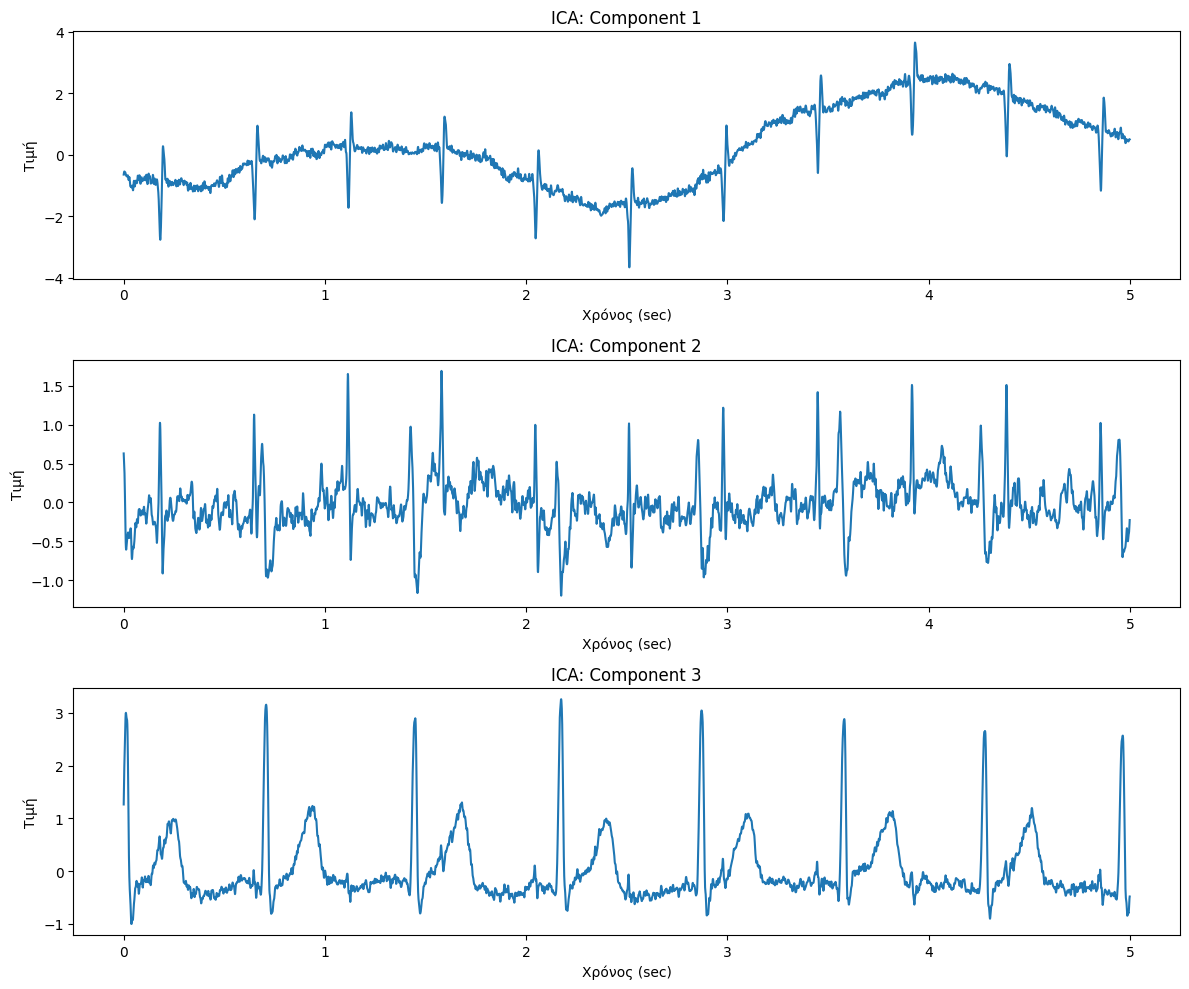

In [7]:
# Εφαρμογή ICA με αριθμό συστατικών (π.χ. 3)
ica = FastICA(n_components=3)
S_ = ica.fit_transform(signals)  # ΟΧΙ filtered_signals !!!!!!!

# Οπτικοποίηση των αποτελεσμάτων (πρώτα 5 δευτερόλεπτα)
time = np.linspace(0, signals.shape[0]/fs, signals.shape[0])
first_n_sec_S = S_[:n_seconds * int(fs), :]

plt.figure(figsize=(12, 10))
for i in range(S_.shape[1]):
    plt.subplot(S_.shape[1], 1, i + 1)
    plt.plot(time[:n_seconds * int(fs)], first_n_sec_S[:, i])
    plt.title(f'ICA: Component {i+1}')
    plt.xlabel('Χρόνος (sec)')
    plt.ylabel('Τιμή')
plt.tight_layout()
plt.show()

# QRS

In [ ]:
# Διαδρομή προς τα δεδομένα
data_path = '/content/abdominal-and-direct-fetal-ecg-database-1.0.0/r01.edf'

fs = 1000

# Διαβάζουμε το ECG σήμα
f = pyedflib.EdfReader(data_path)

# Διαβάζουμε τα annotations (QRS peaks)
annotation = wfdb.rdann(data_path, "qrs")

# Εμφάνιση των timestamps των QRS peaks
print("QRS detections (sample indices):", annotation.sample)

# Υπολογισμός του καρδιακού ρυθμού (bpm)
RR_intervals = np.diff(annotation.sample)   # Διαφορές μεταξύ διαδοχικών QRS peaks
HR_bpm = 60 / (RR_intervals / fs)           # Υπολογισμός καρδιακού ρυθμού
print("Heart Rate (bpm):", HR_bpm)

f._close()  # Κλείσιμο του αρχείου

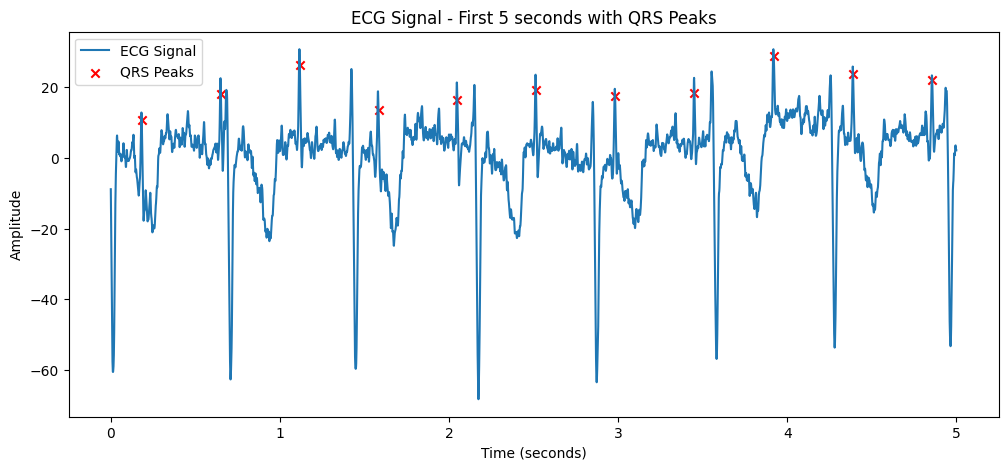

In [38]:
# Επιλογή καναλιού για οπτικοποίηση
n_seconds = 5
num_samples = int(n_seconds * fs)  # Δείγματα που αντιστοιχούν στα 5 πρώτα δευτερόλεπτα
time = np.arange(num_samples) / fs  # Χρονικός άξονας σε sec

# Επιλέγουμε το πρώτο κανάλι για εμφάνιση
channel_idx = 1
signal_5sec = signals[:num_samples, channel_idx]

qrs_peaks = annotation.sample

# Επιλέγουμε τα QRS peaks που είναι μέσα στα πρώτα 5 sec
qrs_5sec = qrs_peaks[qrs_peaks < num_samples]

# Οπτικοποίηση των πρώτων 5 δευτερολέπτων του ΗΚΓ με τα QRS peaks
plt.figure(figsize=(12, 5))
plt.plot(time, signal_5sec, label="ECG Signal")
plt.scatter(qrs_5sec / fs, signal_5sec[qrs_5sec], color='red', marker='x', label="QRS Peaks")
plt.title(f"ECG Signal - First {n_seconds} seconds with QRS Peaks")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()
